# 节点同配性系数与相关性度量

在本教程中，我们将探讨同配性 [^1] 的理论及其度量方法。

我们将重点关注 NetworkX 中 [`algorithms/assortativity/correlation.py`](https://github.com/networkx/networkx/blob/main/networkx/algorithms/assortativity/correlation.py) 提供的同配性度量：
* 属性同配性
* 数值同配性
* 度同配性

以及与同配性度量密切相关的混合矩阵。

## 导入包

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import copy
import random
import warnings

%matplotlib inline

## 同配性

网络中的同配性指的是节点倾向于与“相似”的节点连接，而不是与“不相似”的节点连接。

这里我们说两个节点在某个属性上是“相似”的，如果它们在该属性上具有相同的值。属性可以是任何结构属性，如节点的度，也可以是其他属性，如权重或容量。

基于这些属性，我们可以有不同的网络同配性度量。另一方面，我们也可以有异配性，在这种情况下，节点倾向于与不相似的节点连接，而不是与相似的节点连接。

### 同配性系数

假设我们有一个网络 $N$，$N = (V, E)$，其中 $V$ 是网络中的节点集合，$E$ 是网络中的边/有向边集合。此外，$P(v)$ 表示每个节点 $v$ 的一个属性。

#### 混合矩阵

设属性 $P(v)$ 在网络中取 $P[0], P[1], ... P[k-1]$ 这些不同的值，那么**混合矩阵**是一个矩阵 $M$，其中 $M[i][j]$ 表示从具有属性 $P[i]$ 的节点到具有属性 $P[j]$ 的节点的边的数量。我们可以通过除以有序边的总数来归一化混合矩阵，即 $e = \frac{M}{|E|}$。

现在定义，

$a[i] =$ 比例的边 $(u, v)$ 使得 $P(u) = P[i]$

$$ a[i] = \sum\limits_{j} e[i][j] $$

$b[i] =$ 比例的边 $(u, v)$ 使得 $P(v) = P[i]$

$$ b[i] = \sum\limits_{j} e[j][i] $$

在 Python 代码中，它看起来像是 `a = e.sum(axis=0)` 和 `b = e.sum(axis=1)`

最后，设 $\sigma_a$ 和 $\sigma_b$ 分别表示 $\{\ P[i] \cdot a[i] \ |\ i \in 0...k-1 \}$ 和 $\{\ P[i] \cdot b[i] \ |\ i \in 0...k-1 \}$ 的标准差。

然后我们可以基于皮尔逊相关系数定义该属性的同配性系数。

#### 属性同配性系数

这里的属性 $P(v)$ 是分配给每个节点的名义属性。如上所述，我们计算归一化混合矩阵 $e$，并由此定义属性同配性系数 [^2] 如下。

从这里开始，我们将使用下标表示索引，例如 $P_i = P[i]$ 和 $e_{ij} = e[i][j]$

$$ r = \frac{\sum\limits_{i} e_{ii} - \sum\limits_{i} a_{i} b_{i}}{1 - \sum\limits_{i} a_{i} b_{i}} = \frac{Trace(e) - ||e^2||}{1 - ||e^2||} $$

它被实现为 `attribute_assortativity_coefficient`。

#### 数值同配性系数

这里的属性 $P(v)$ 是分配给每个节点的数值属性，归一化混合矩阵 $e$、$\sigma_a$ 和 $\sigma_b$ 的定义与上述相同。由此我们定义数值同配性系数 [^2] 如下。

$$ r = \frac{\sum\limits_{i,j} P_i P_j (e_{ij} - a_i b_j)}{\sigma_a \sigma_b} $$

它被实现为 `numeric_assortativity_coefficient`。

#### 度同配性系数

在测量有向网络的度同配性时，我们比针对某个属性的同配性有更多的选择，因为我们有两种类型的度，即入度和出度。基于这两种度，我们可以测量 $2 \times 2 = 4$ 种不同的度同配性 [^3]：

1. r(in, in) : 测量有向边 (u, v) 的倾向，使得 in-degree(u) = in-degree(v)。
2. r(in, out) : 测量有向边 (u, v) 的倾向，使得 in-degree(u) = out-degree(v)。
3. r(out, in) : 测量有向边 (u, v) 的倾向，使得 out-degree(u) = in-degree(v)。
4. r(out, out) : 测量有向边 (u, v) 的倾向，使得 out-degree(u) = out-degree(v)。

注意：如果网络是无向的，所有四种度同配性都是相同的。

为了定义所有四种度同配性系数，我们需要对 $P[i]$ 和 $e$ 的定义稍作修改，而 $\sigma_a$ 和 $\sigma_b$ 的定义保持不变。
设 $x,y \in \{in,out\}$。属性 $P(\cdot)$ 取值于 $x$-degree$(\cdot)$ 和 $y$-degree$(\cdot)$ 取值的并集，且 $e_{i,j}$ 表示具有 $x$-degree$(u) = P_i$ 和 $y$-degree$(v) = P_j$ 的有向边 $(u,v)$ 的比例。

$$ r(x,y) = \frac{\sum\limits_{i,j}P_i P_j(e_{ij} -a_i b_j)}{\sigma_a\sigma_b} $$

该公式通过 `degree_assortativity_coefficient` 和 `degree_pearson_correlation_coefficient` 实现。后者函数使用 `scipy.stats.pearsonr` 计算同配系数，使其可能更快。

## 同配性示例

展示同配性值如何变化

In [2]:
gname = "g2"
G = nx.read_graphml(f"data/{gname}.graphml")
with open(f"data/pos_{gname}", "rb") as fp:
    pos = pickle.load(fp)

/usr/local/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


/tmp/ipykernel_8889/547108271.py:26: UserWarning: Glyph 23646 (\N{CJK UNIFIED IDEOGRAPH-5C5E}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/547108271.py:26: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/547108271.py:26: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/547108271.py:26: UserWarning: Glyph 37197 (\N{CJK UNIFIED IDEOGRAPH-914D}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/547108271.py:26: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/547108271.py:26: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/547108271.py:26: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missi

/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23646 (\N{CJK UNIFIED IDEOGRAPH-5C5E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37197 (\N{CJK UNIFIED IDEOGRAPH-914D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  fig.canvas

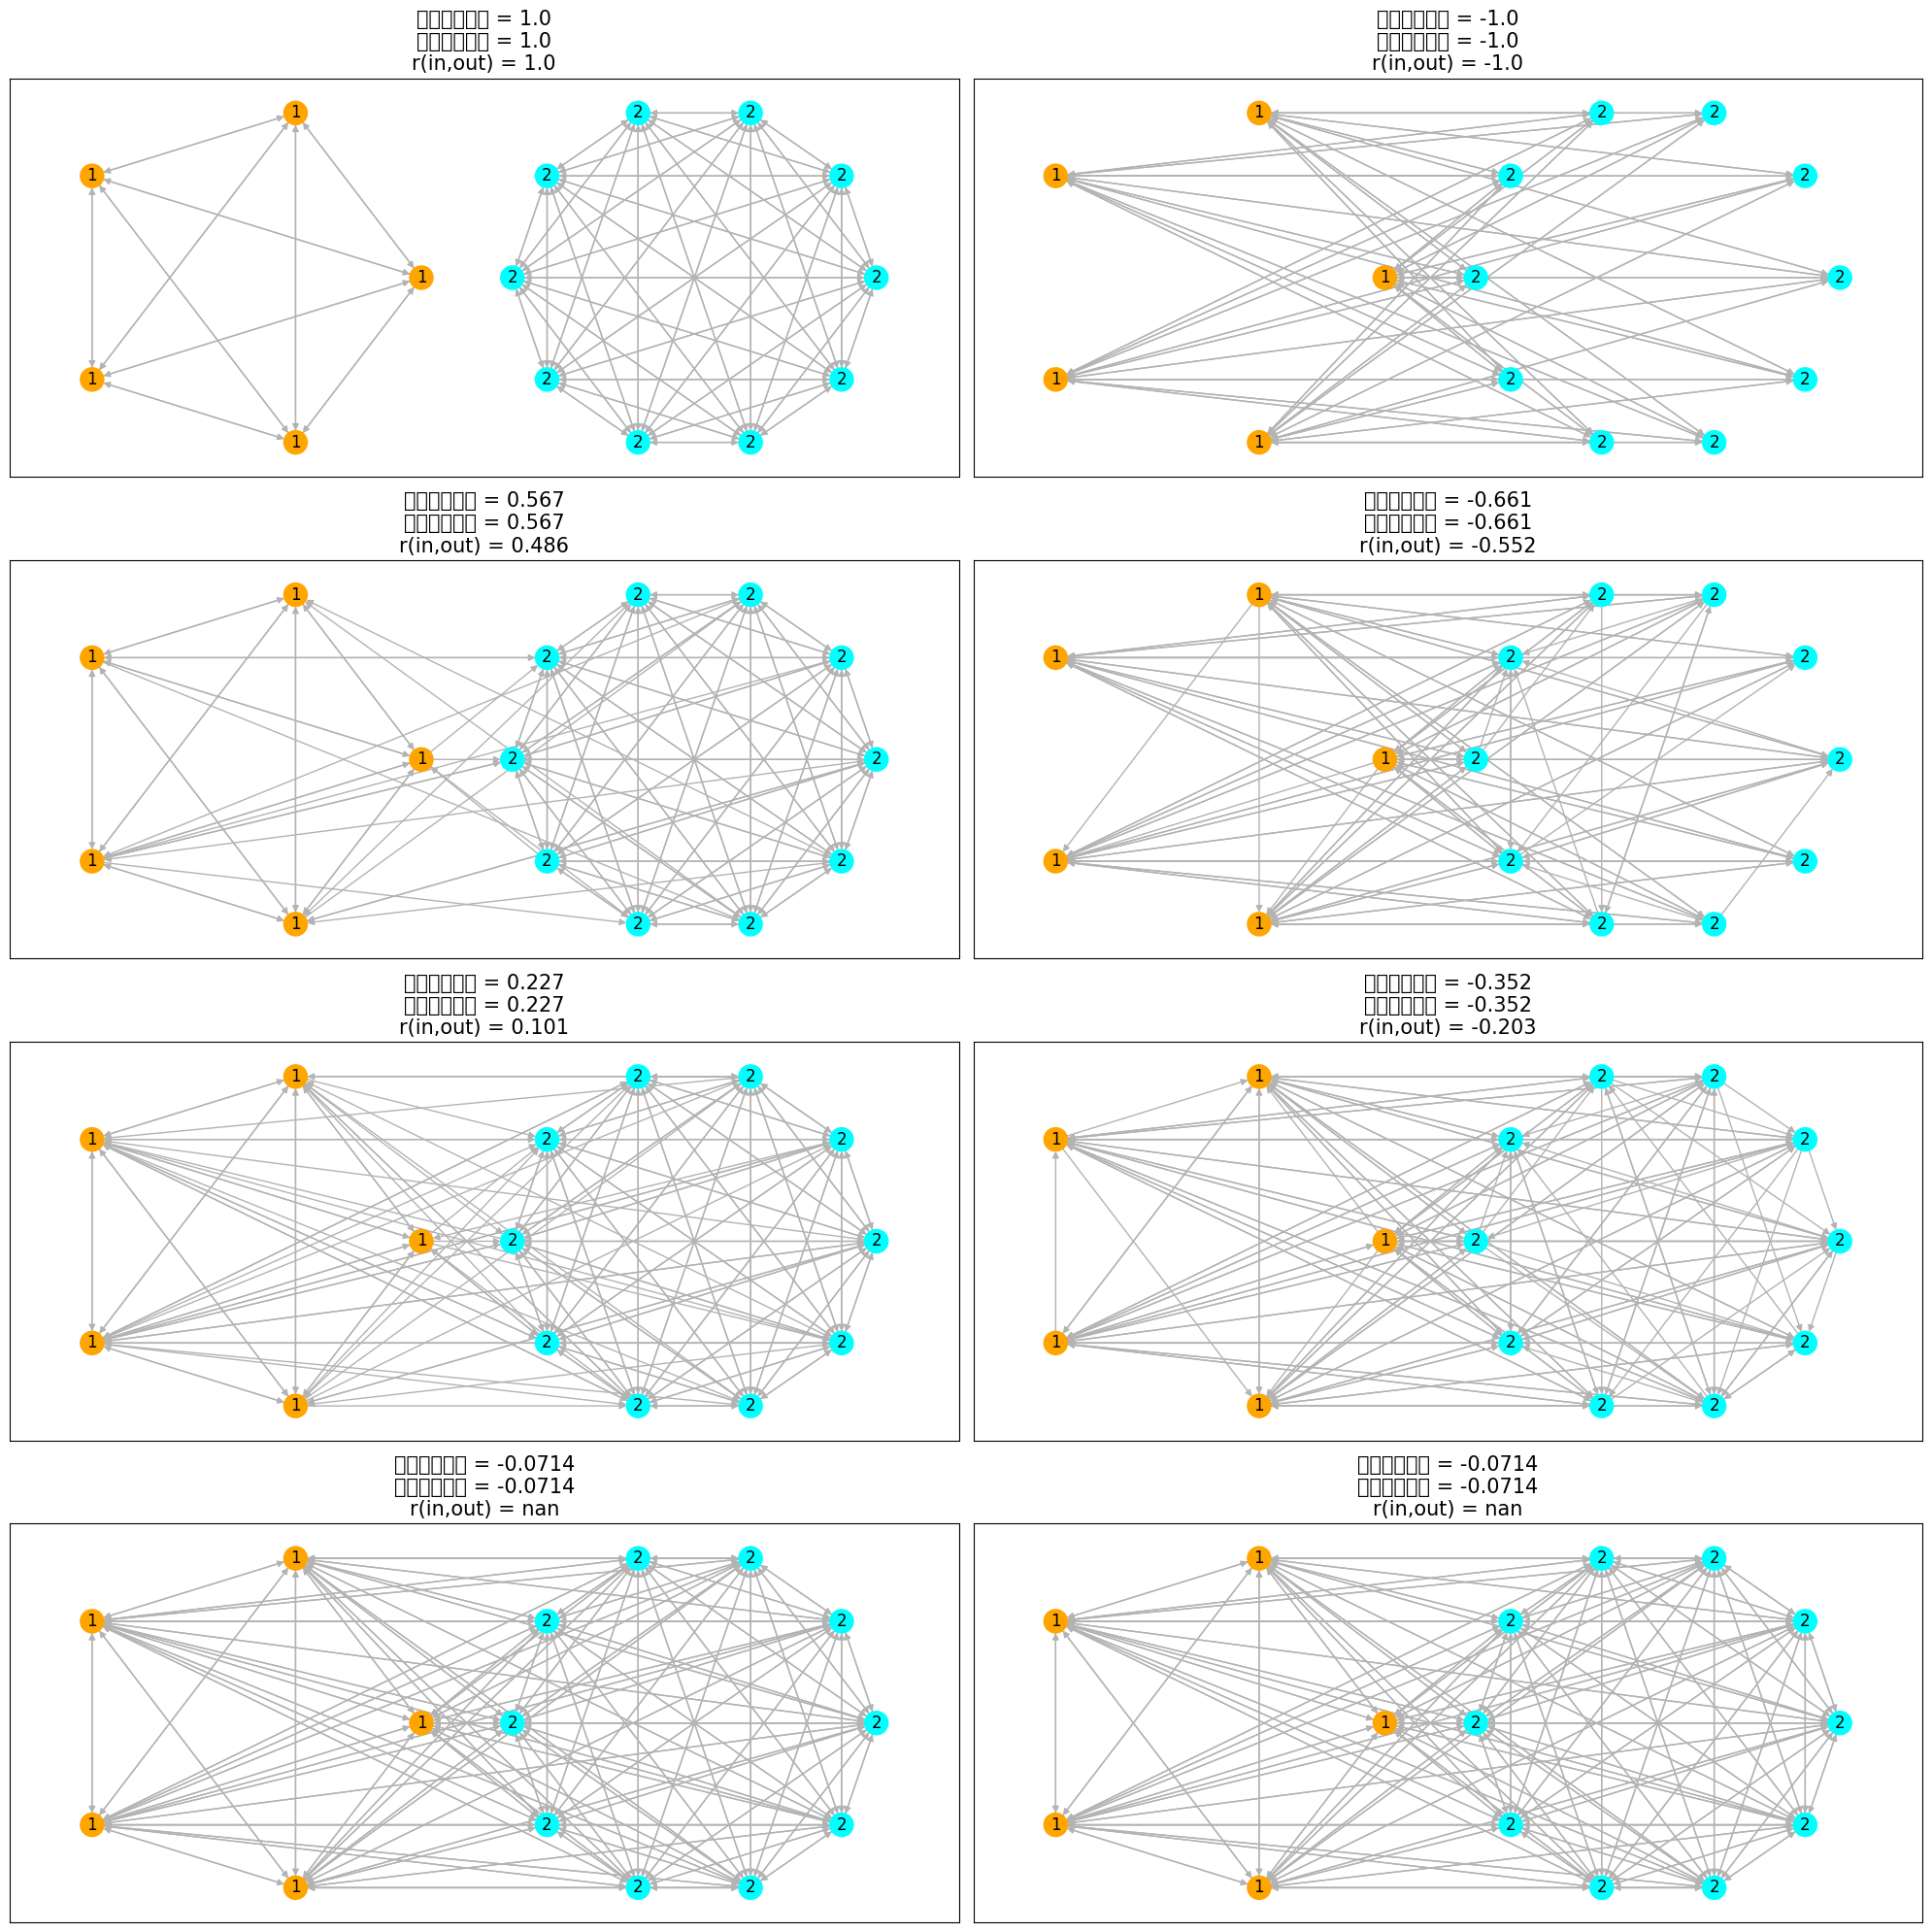

In [3]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

# 根据节点的 'cluster' 和 'num_prop' 属性为节点分配颜色和标签
node_colors = ["orange" if G.nodes[u]["cluster"] == "K5" else "cyan" for u in G.nodes]
node_labels = {u: G.nodes[u]["num_prop"] for u in G.nodes}

for i in range(8):
    g = nx.read_graphml(f"data/{gname}_{i}.graphml")

    # 计算不同属性的同配系数
    cr = nx.attribute_assortativity_coefficient(g, "cluster")
    r_in_out = nx.degree_assortativity_coefficient(g, x="in", y="out")
    nr = nx.numeric_assortativity_coefficient(g, "num_prop")

    # 绘制网络
    nx.draw_networkx_nodes(
        g, pos=pos, node_size=300, ax=axes[i // 2][i % 2], node_color=node_colors
    )
    nx.draw_networkx_labels(g, pos=pos, labels=node_labels, ax=axes[i // 2][i % 2])
    nx.draw_networkx_edges(g, pos=pos, ax=axes[i // 2][i % 2], edge_color="0.7")
    axes[i // 2][i % 2].set_title(
        f"属性同配系数 = {cr:.3}\n数值同配系数 = {nr:.3}\nr(in,out) = {r_in_out:.3}",
        size=15,
    )

fig.tight_layout()

节点根据 `cluster` 属性着色，并根据 `num_prop` 属性标记。我们可以观察到，左侧的初始网络是完全同配的，而其右侧的补网络是完全异配的。当我们在同配（异配）网络中添加不同（相似）属性的节点之间的边时，网络趋向于非同配网络，且两个同配系数的值趋向于 $0$。

`attribute_assortativity_coefficient` 和 `numeric_assortativity_coefficient` 中的参数 `nodes` 指定在混合矩阵计算中要考虑的节点。也就是说，如果 $(u,v)$ 是一条有向边，那么如果 $u$ 在 `nodes` 中，边 $(u,v)$ 将用于混合矩阵计算。对于无向情况，只要 $u,v$ 中至少有一个在 `nodes` 中，就会被考虑。

`degree_assortativity_coefficient` 和 `degree_pearson_correlation_coefficient` 中的 `nodes` 参数解释不同，它指定形成子图的节点，其边在混合矩阵计算中被考虑。

/usr/local/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)
/tmp/ipykernel_8889/3351415280.py:49: UserWarning: Glyph 23646 (\N{CJK UNIFIED IDEOGRAPH-5C5E}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/3351415280.py:49: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/3351415280.py:49: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/3351415280.py:49: UserWarning: Glyph 37197 (\N{CJK UNIFIED IDEOGRAPH-914D}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/3351415280.py:49: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_8889/3351415280.py:49: UserWarning: Glyph 25968 (\N{C

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 33410 (\N{CJK UNIFIED IDEOGRAPH-8282}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 33410 (\N{CJK UNIFIED IDEOGRAPH-8282}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


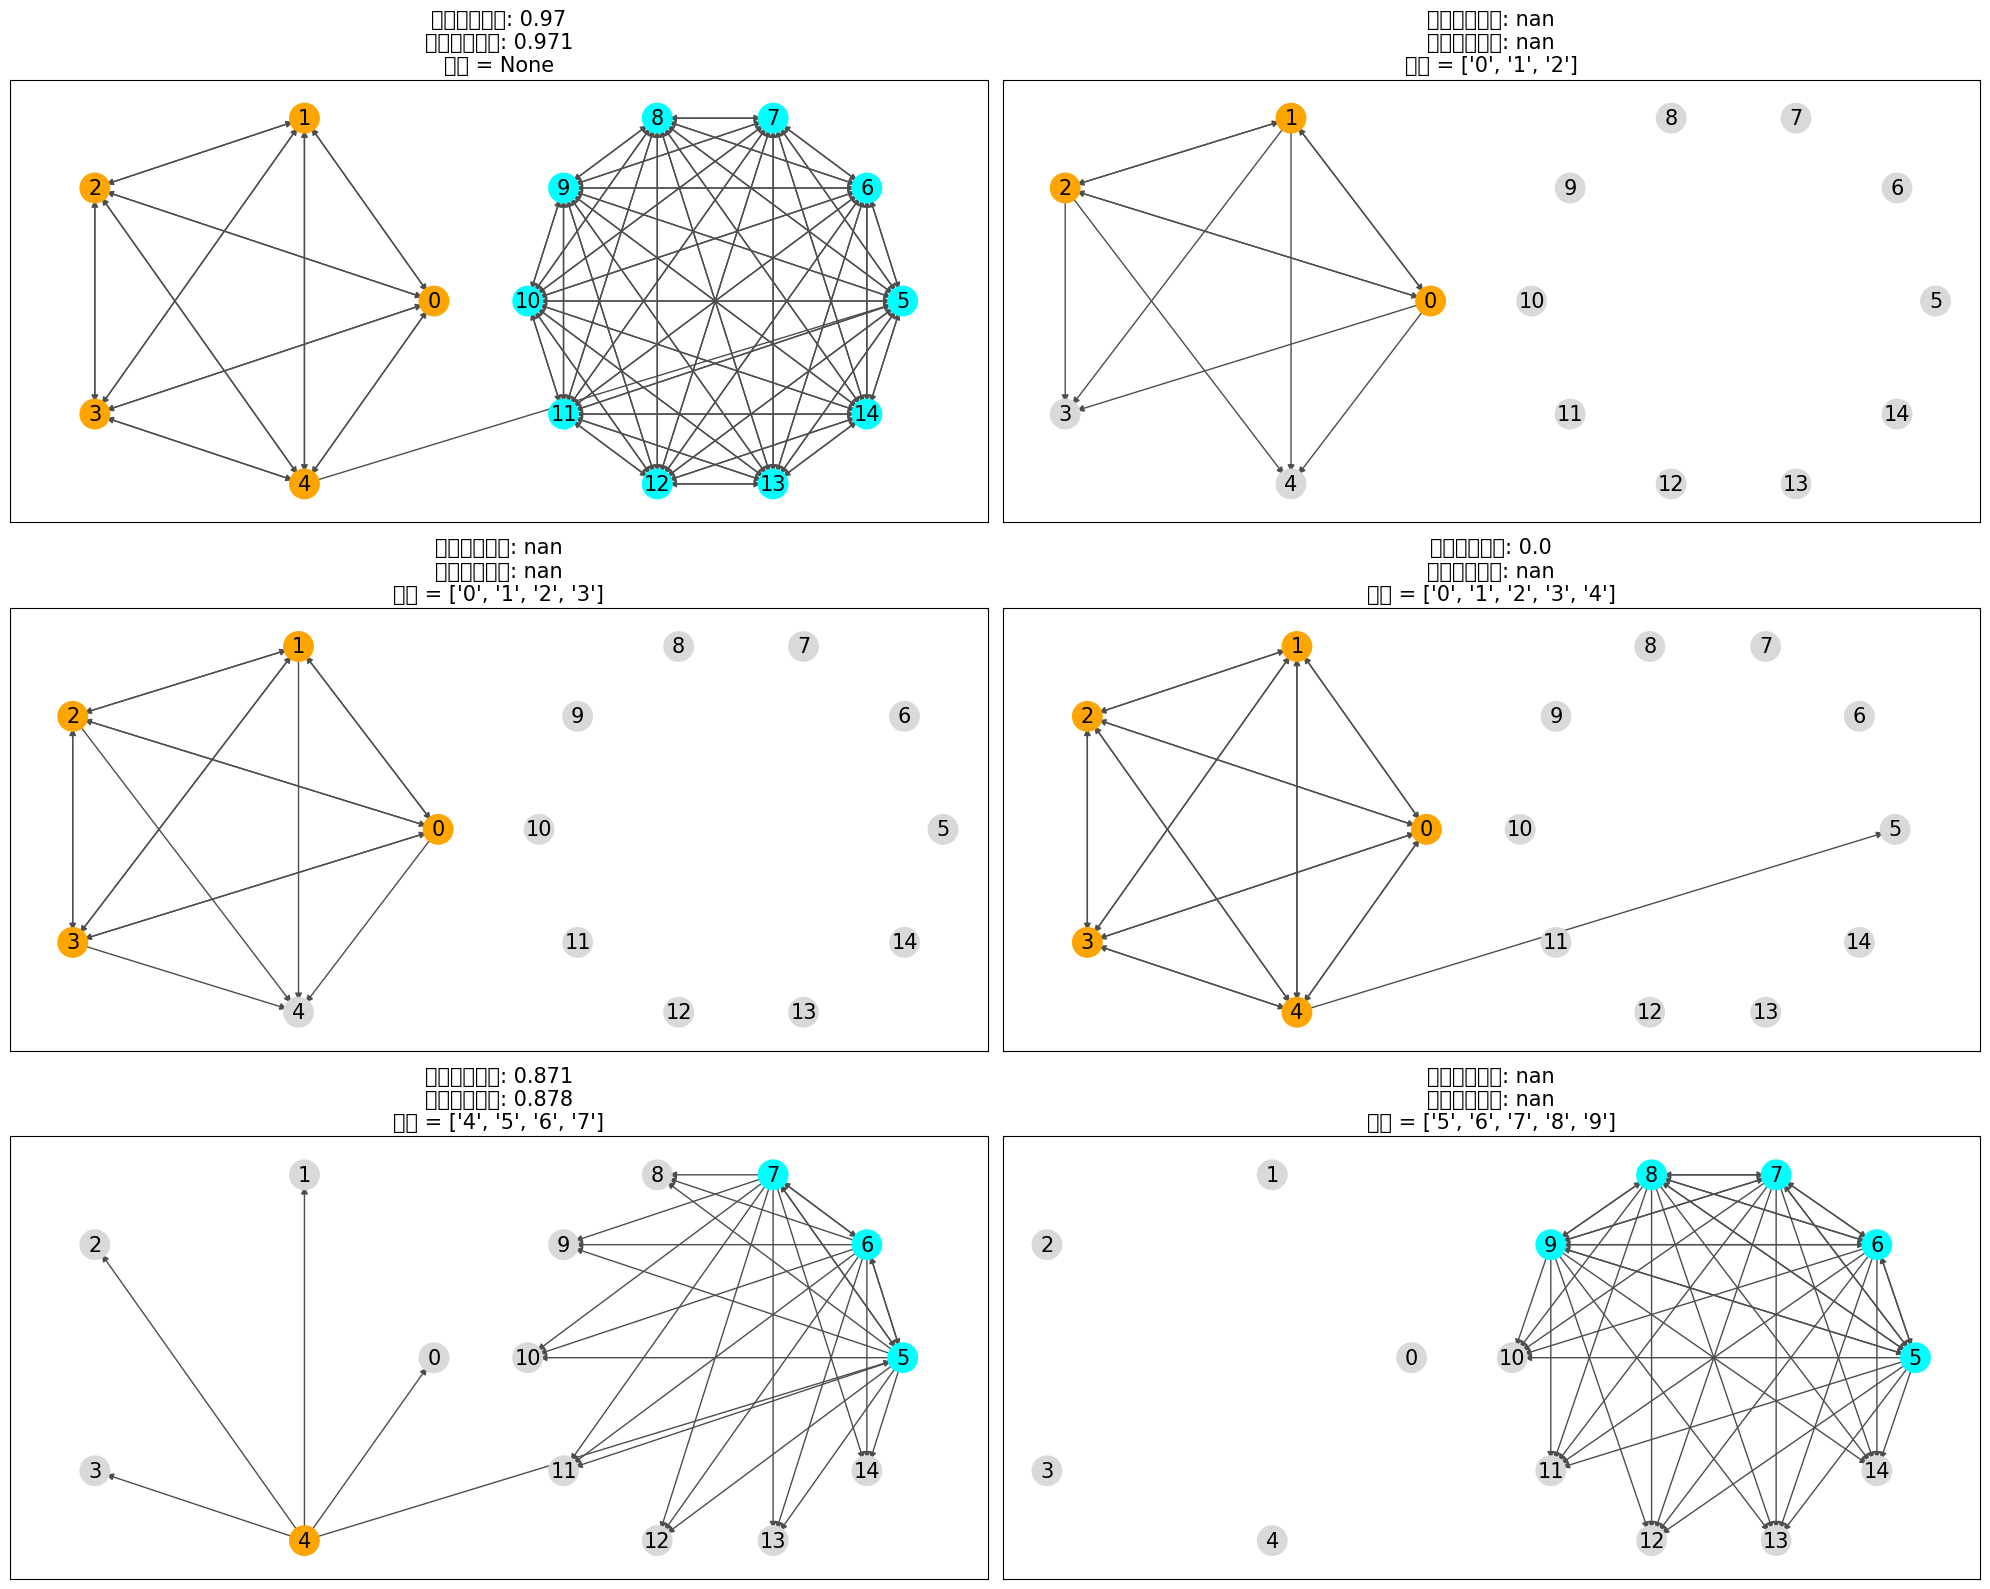

In [4]:
# 示例中第 i 个网络要考虑的节点列表
# 注意：传递 'None' 意味着考虑所有节点
nodes_list = [
    None,
    [str(i) for i in range(3)],
    [str(i) for i in range(4)],
    [str(i) for i in range(5)],
    [str(i) for i in range(4, 8)],
    [str(i) for i in range(5, 10)],
]
fig, axes = plt.subplots(3, 2, figsize=(20, 16))


def color_node(u, nodes):
    """根据节点属性给出节点颜色的实用函数"""
    if u not in nodes:
        return "0.85"
    if G.nodes[u]["cluster"] == "K5":
        return "orange"
    else:
        return "cyan"


# 添加一条边以展示边缘情况
G.add_edge("4", "5")

for nodes, ax in zip(nodes_list, axes.ravel()):
    # 计算同配性值
    cr = nx.attribute_assortativity_coefficient(G, "cluster", nodes=nodes)
    nr = nx.numeric_assortativity_coefficient(G, "num_prop", nodes=nodes)

    # 绘制网络
    ax.set_title(
        f"属性同配系数: {cr:.3}\n数值同配系数: {nr:.3}\n节点 = {nodes}",
        size=15,
    )
    if nodes is None:
        nodes = [u for u in G.nodes()]
    node_colors = [color_node(u, nodes) for u in G.nodes]
    nx.draw_networkx_nodes(G, pos=pos, node_size=450, ax=ax, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, labels={u: u for u in G.nodes}, font_size=15, ax=ax)
    nx.draw_networkx_edges(
        G,
        pos=pos,
        edgelist=[(u, v) for u, v in G.edges if u in nodes],
        ax=ax,
        edge_color="0.3",
    )
fig.tight_layout()

在上面的图中，只有被考虑的节点被着色，其余节点被灰化，并且只有同配性计算中考虑的边被绘制。

## 参考文献

[^1]: [Wikipedia, 同配性](https://en.wikipedia.org/wiki/Assortativity)
[^2]: M. E. J. Newman, 网络中的混合模式 <https://doi.org/10.1103/PhysRevE.67.026126>

[^3]: Foster, J.G., Foster, D.V., Grassberger, P. & Paczuski, M. 边缘方向与网络结构 <https://doi.org/10.1073/pnas.0912671107>